# Comparison of Station Data and HRDPS

In [15]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

In [16]:
#bring in data
hrdps = xr.open_dataset("hrdps_day_avgs_postSep2014.nc")
racerocks = pd.read_csv("RaceRocks.csv")
#sheringham = pd.read_csv("Sheringham.csv")

In [88]:
#trim hrdps data to fit into timespan
a= hrdps.sel(time_counter=slice('2015-01-01T00:00:00.000000000', '2016-02-28T00:00:00.000000000'))
b= hrdps.sel(time_counter=slice('2016-03-01T00:00:00.000000000', '2020-02-28T00:00:00.000000000'))
c= hrdps.sel(time_counter=slice('2020-03-01T00:00:00.000000000', '2020-12-31T00:00:00.000000000'))
hrdps= xr.concat([a,b,c],dim='time_counter')

In [17]:
#bring in PCA results
direc_eigvecs = pd.read_csv('direc_hrdps_eigvecs.csv',header=None).to_numpy()
direc_fracvar = pd.read_csv('direc_hrdps_fracVar.csv',header=None)[0].to_numpy()
direc_PCs = pd.read_csv('direc_hrdps_PCs.csv',header=None).to_numpy()
speed_eigvecs = pd.read_csv('speed_hrdps_eigvecs.csv',header=None).to_numpy()
speed_fracvar = pd.read_csv('speed_hrdps_fracVar.csv',header=None)[0].to_numpy()
speed_PCs = pd.read_csv('speed_hrdps_PCs.csv',header=None).to_numpy()

hrdps_lat = pd.read_csv('hrdps_lat.csv',header=None)[0].to_numpy()
hrdps_lon = pd.read_csv('hrdps_lon.csv',header=None)[0].to_numpy()

In [18]:
#bring in seasonal cycle results
season_speed = pd.read_csv('speed_daily_seasonal.csv',header=None).to_numpy()
season_direc = pd.read_csv('direc_daily_seasonal.csv',header=None).to_numpy()

In [19]:
#generate dates that current extend of hrdps data falls within
time2015 = pd.date_range(start=datetime.datetime(2015,1,1),end=datetime.datetime(2020,12,31))
time2015 = np.delete(time2015,[list(time2015).index(datetime.datetime(2016,2,29)),list(time2015).index(datetime.datetime(2020,2,29))])

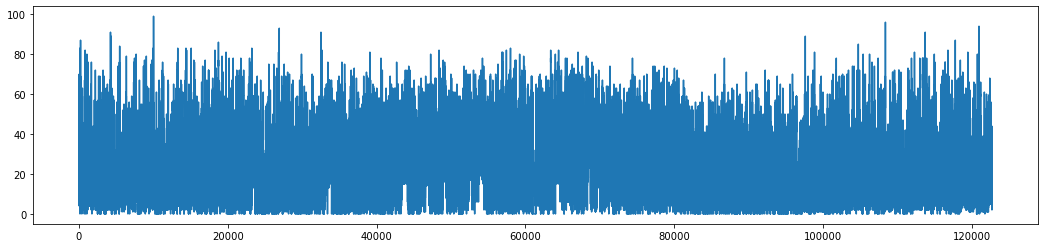

In [20]:
#plot the wind data at both stations
plt.figure(figsize=(18,4))
plt.plot(racerocks['Wind Spd (km/h)'])
#plt.plot(sheringham['Wind Spd (km/h)']) #much more gaps in sheringham wind data (pressure is comparible), focus on racerocks

In [21]:
racerocks['Date/Time (LST)']=pd.to_datetime(racerocks['Date/Time (LST)'])

In [22]:
racerocks['Date/Time (LST)']

0        2007-01-01 00:00:00
1        2007-01-01 01:00:00
2        2007-01-01 02:00:00
3        2007-01-01 03:00:00
4        2007-01-01 04:00:00
                 ...        
122731   2020-12-31 19:00:00
122732   2020-12-31 20:00:00
122733   2020-12-31 21:00:00
122734   2020-12-31 22:00:00
122735   2020-12-31 23:00:00
Name: Date/Time (LST), Length: 122736, dtype: datetime64[ns]

In [66]:
#take Race Rocks daily average
RR_davg = racerocks.resample('D', on='Date/Time (LST)').mean()

In [67]:
#trim racerocks data to be for same time extent as hrdps
RR_davg = RR_davg[min(time2015):max(time2015)]
RR_davg = RR_davg.drop([datetime.datetime(2016,2,29),datetime.datetime(2020,2,29)],axis=0)

In [68]:
#flip the racerocks direction data so that it is the same way that ocenaographers look at it
for i in range(len(RR_davg['Wind Dir (10s deg)'])):
    RR_davg['Wind Dir (10s deg)'][i]=RR_davg['Wind Dir (10s deg)'][i]+18
    if RR_davg['Wind Dir (10s deg)'][i]>=36:
        RR_davg['Wind Dir (10s deg)'][i]=RR_davg['Wind Dir (10s deg)'][i]-36

In [69]:
RR_davg

,Longitude (x),Latitude (y),Temp (°C),Wind Dir (10s deg),Wind Spd (km/h),Stn Press (kPa)
Date/Time (LST),,,,,,
2015-01-01,-123.53,48.3,3.291667,26.708333,17.041667,102.247500
2015-01-02,-123.53,48.3,5.512500,33.541667,15.125000,101.630000
2015-01-03,-123.53,48.3,5.929167,24.083333,20.041667,101.990417
2015-01-04,-123.53,48.3,6.770833,24.458333,19.125000,101.367083
2015-01-05,-123.53,48.3,9.062500,28.916667,17.958333,101.642917
...,...,...,...,...,...,...
2020-12-27,-123.53,48.3,7.033333,25.458333,27.333333,101.360000
2020-12-28,-123.53,48.3,6.383333,22.250000,14.083333,101.667917
2020-12-29,-123.53,48.3,5.250000,27.416667,21.458333,101.889167


## Find the index of the closest HRDPS grid cell to Race Rocks

In [25]:
# hrdps_lat = hrdps.nav_lat.values.flatten()
# hrdps_lon = hrdps.nav_lon.values.flatten()

In [26]:
#want to isolate HRDPS data from nav_lat and nav_lon close to RaceRocks
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#Racerocks located at lat =48.3 lon =-123.53
lat = racerocks['Latitude (y)'][0]
lon = racerocks['Longitude (x)'][0]+360 #the lat and lon we want to aim for
buffer = 0.01 #play around in this until narrowed in on one best values
ind=0

for i in range(len(hrdps_lon)):
    if hrdps_lon[i] > (lon-buffer) and hrdps_lon[i] < (lon+buffer) and hrdps_lat[i] > (lat-buffer) and hrdps_lat[i] < (lat+buffer):
        ind=i

# closest = find_nearest(hrdps_lat,racerocks['Latitude (y)'][0])
# lat_ind = np.where(hrdps_lat == closest)[0][0]

# closest = find_nearest(hrdps_lon,racerocks['Longitude (x)'][0]+360)
# lon_ind = np.where(hrdps_lon == closest)[0][0]

print('HRDPS closest lat= '+str(hrdps_lat[ind])+', closest lon= '+str(hrdps_lon[ind]))

HRDPS closest lat= 48.29035764694796, closest lon= 236.4652931642128


*Trim eigenvectors according according to this index*

In [27]:
speed_eigvecs = speed_eigvecs[:,ind]
direc_eigvecs = direc_eigvecs[:,ind]

## Pre-reconstruction comparison

In [89]:
u= hrdps.u_wind.values
v = hrdps.v_wind.values
speed_temp = np.sqrt(np.add(np.square(u),np.square(v)))
direc_temp = np.arctan2(u,v)

In [90]:
#get into shape we can work with
speed_hrdps = np.empty((np.shape(speed_temp)[1]*np.shape(speed_temp)[2],np.shape(speed_temp)[0]))
for i in range(np.shape(speed_temp)[0]):
    speed_hrdps[:,i] = np.reshape(speed_temp[i],(np.shape(speed_temp)[1]*np.shape(speed_temp)[2],))
    
direc_hrdps = np.empty((np.shape(direc_temp)[1]*np.shape(direc_temp)[2],np.shape(direc_temp)[0]))
for i in range(np.shape(direc_temp)[0]):
    direc_hrdps[:,i] = np.reshape(direc_temp[i],(np.shape(direc_temp)[1]*np.shape(direc_temp)[2],))

In [91]:
#trim so that its just the index we care about 
speed_hrdps=speed_hrdps[ind,:]
direc_hrdps=direc_hrdps[ind,:]

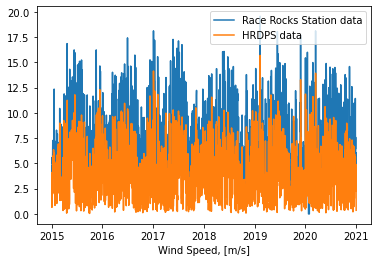

In [93]:
#plot comparison to racerocks
#first speed
plt.plot(time2015,RR_davg['Wind Spd (km/h)']*1000*(1/3600),label='Race Rocks Station data')
plt.plot(time2015,speed_hrdps, label='HRDPS data')
plt.xlabel('Wind Speed, [m/s]')
plt.legend()

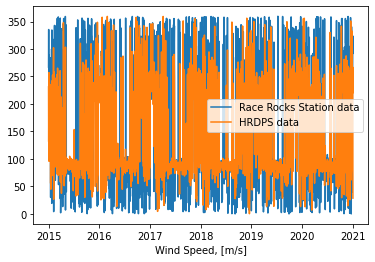

In [95]:
#direction
#HRPDS direction results are in +ve and -ve radians, must convert to degrees between 0 and 360
for i in range(len(direc_hrdps)):
    if direc_hrdps[i] >0:
        direc_hrdps[i] = direc_hrdps[i]*(180/math.pi)
    if direc_hrdps[i] <0:
        direc_hrdps[i] = direc_hrdps[i]*(180/math.pi)+360


plt.plot(time2015,RR_davg['Wind Dir (10s deg)']*10,label='Race Rocks Station data')
plt.plot(time2015,direc_hrdps, label='HRDPS data')
plt.xlabel('Wind Speed, [m/s]')
plt.legend()

## Reconstruction
Speed:

In [28]:
#determine the number of modes required for x% variance to be explained in speed
x= 0.90
kk = 0

for i in range(len(speed_fracvar)):
    kk+=speed_fracvar[i]
    if kk >= x:
        n=i 
        break
print(str(n)+" modes required to account for " +str(x*100)+"% of the variance.")

7 modes required to account for 90.0% of the variance.


In [29]:
#reconstruct 
eigvecs = speed_eigvecs[:,np.newaxis]
REC = eigvecs[:n,:].T@speed_PCs[:,:n].T# + np.mean(pd.DataFrame.to_numpy(d[2:]))
REC = REC[0,:]

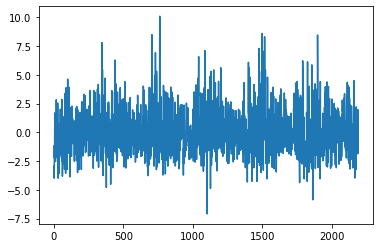

In [30]:
plt.plot(REC)

In [31]:
#add seasonal cycle back
#first we need to remove all irrelevant infro from season_speed (only care about the tile closest to RaceRocks)
season6yr_speed = season_speed[ind,:]

#then make this cycle for the full 6 year run and add to the reconstructed data
nyears=6
REC = REC+ np.tile(season6yr_speed,(1,nyears))
REC = REC[0,:]

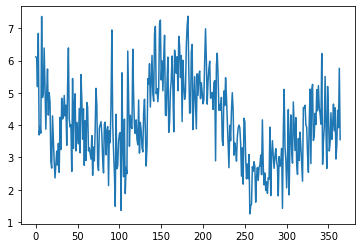

In [32]:
plt.plot(season6yr_speed)

In [33]:
#calculate the correlation between racerocks and HRDPS
r = np.corrcoef(REC,RR_davg['Wind Spd (km/h)']*1000*(1/3600))[0][1]

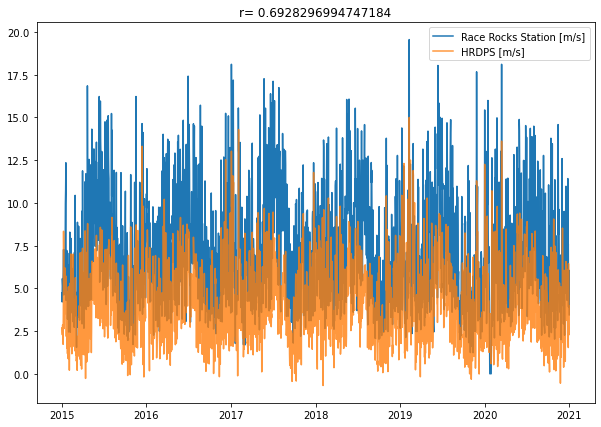

In [34]:
plt.figure(figsize=(10,7))
plt.plot(time2015,RR_davg['Wind Spd (km/h)']*1000*(1/3600),label='Race Rocks Station [m/s]')#,alpha=0.9)
plt.plot(time2015,REC,alpha=0.8,label='HRDPS [m/s]')
plt.title('r= '+str(r))
plt.legend()

Direction:

In [70]:
#determine the number of modes required for x% variance to be explained in direction
x= 0.90
kk = 0

for i in range(len(direc_fracvar)):
    kk+=direc_fracvar[i]
    if kk >= x:
        n=i 
        break
print(str(n)+" modes required to account for " +str(x*100)+"% of the variance.")

306 modes required to account for 90.0% of the variance.


In [71]:
#reconstruct 
eigvecs = direc_eigvecs[:,np.newaxis]
REC = eigvecs[:n,:].T@direc_PCs[:,:n].T# + np.mean(pd.DataFrame.to_numpy(d[2:]))
REC = REC[0,:]

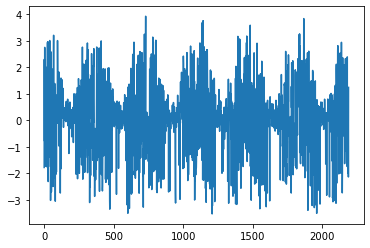

In [72]:
plt.plot(REC)

In [73]:
#add seasonal cycle back
#first we need to remove all irrelevant infro from season_speed (only care about the tile closest to RaceRocks)
season_direc6yr = season_direc[ind,:]

#then make this cycle for the full 6 year run and add to the reconstructed data
nyears=6
REC = REC+ np.tile(season_direc6yr,(1,nyears))
REC = REC[0,:]

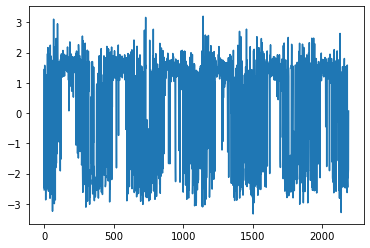

In [74]:
plt.plot(REC)

In [75]:
#HRPDS direction results are in +ve and -ve radians, must convert to degrees between 0 and 360
for i in range(len(REC)):
    if REC[i] >0:
        REC[i] = REC[i]*(180/math.pi)
    if REC[i] <0:
        REC[i] = REC[i]*(180/math.pi)+360

In [76]:
#calculate the correlation between racerocks and HRDPS
r = np.corrcoef(REC,RR_davg['Wind Dir (10s deg)']*10)[0][1]

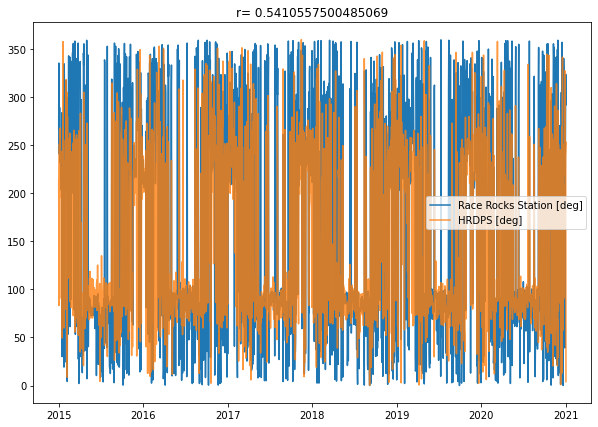

In [77]:
plt.figure(figsize=(10,7))
plt.plot(time2015,RR_davg['Wind Dir (10s deg)']*10,label='Race Rocks Station [deg]')#,alpha=0.9)
plt.plot(time2015,REC,alpha=0.8,label='HRDPS [deg]')
plt.title('r= '+str(r))
plt.legend()